In [20]:
%load_ext autoreload 
%autoreload 2

%aimport -pandas
%aimport -scipy.stats
%aimport -numpy
%aimport -matplotlib.pyplot


import default_calcs as default
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import scipy.stats as stats
import pandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
default.default_rate_normal_dist(-2,.3,.01)

In [ ]:
a  = stats.norm.ppf(.01)

In [ ]:
# x = effects of economic driver
x = np.linspace(-3,3,100)

In [ ]:
x_dist = stats.norm.pdf(x)

In [ ]:
plt.plot(x,a_dist)
plt.show()

In [ ]:
defaults= default.default_rate_normal_dist(x,.5,.01)

In [ ]:
plt.plot(x,defaults)
plt.show()

In [ ]:
# cum default probability
cum_def = default.inv_default_rate_normal_dist(.01,.3,defaults)

In [ ]:
df = pandas.DataFrame(data=[defaults,(cum_def)]).T
df.columns=['defaults','cum_def']

In [ ]:
df.tail()

In [ ]:
plt.plot(defaults,x_dist.cumsum())
plt.show()

In [ ]:
len(cum_def)

In [ ]:
import prepayment_calcs as pc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
fast_smm = np.random.randint(50,100,size=60)/1000

In [ ]:
a = pc.prepayment_curve_from_passive_active_composition(.09, .8, .01, .2, 60)

In [ ]:
a.plot(a.index,['fast_amount','pool_cpr'])
plt.grid()
plt.show()

In [ ]:
a['total'] = a.fast_amount + a.slow_amount

In [ ]:
a.head()

In [ ]:
from bs4 import BeautifulSoup
import requests

In [ ]:
USD_LIBOR = BeautifulSoup(requests.get("http://www.global-rates.com/interest-rates/libor/american-dollar/american-dollar.aspx").text,
                         "html.parser")

In [ ]:
USD_LIBOR.title

In [ ]:
balances = np.array([[50000],[100000],[150000],[200000],[250000]])
coupon = np.array([0.04,0.06,0.08,0.10,0.12,.14])

In [ ]:
df = pd.DataFrame(np.pmt(rate=coupon/12,nper=360,pv=balances)).T

In [ ]:
np.arange(1,10)

In [ ]:
nper=360
pv=400000
cpn=0.055/12
df = pd.DataFrame(data=np.zeros([nper+1,1]),columns=['scheduled_balance'],
                 index =[np.arange(0,nper+1)])
df.loc[0,'scheduled_balance'] = pv

In [ ]:
def scheduled_balances(rate, nper, pv):
    df = pd.DataFrame(data=np.zeros([nper + 1, 1]), columns=['scheduled_balance'],
                      index=[np.arange(0, nper + 1)])
    df.loc[0, 'scheduled_balance'] = pv

    df['bal_percent'] = (1 - ((((1 + rate) ** np.array(df.index)) - 1) /
                           (((1 + rate) ** df.index.max()) - 1)))

    df.loc[:, 'scheduled_balance'] = df['bal_percent'] * df.loc[0,'scheduled_balance']

    return df

In [ ]:
df1 = scheduled_balances(0.055/12,360,400000)

In [ ]:
def scheduled_balance_percent(rate, nper, age):
    return (1 - ((((1 + rate) ** age) - 1) /
          (((1 + rate) ** nper) - 1)))

In [ ]:
scheduled_balance_percent(0.06/12,360,60)

In [ ]:
coupon = list([0.06, 0.08, 0.10])
age = list([60,120,180,240,300,359])

In [ ]:
results = []
for i in coupon:
    column = []
    for j in age:
        column.append(scheduled_balance_percent(i/12, 360, j))
    results.append(column)

In [ ]:
df = pd.DataFrame(results).T
df.columns=coupon
df.index=age

In [ ]:
df

In [ ]:
df = pd.DataFrame(data=np.zeros([nper + 1, 1]), columns=['scheduled_balance'],
                      index=[np.arange(0, nper + 1)])
df.loc[0, 'scheduled_balance'] = pv

In [ ]:
rate = 0.055
nper = 360

df['bal_percent'] = df.reset_index()['index'].apply(lambda x: 
                                                    scheduled_balance_percent(
                                                    rate/12, nper, x))

In [ ]:
def scheduled_balances(rate, nper, pv):
    """ Returns data frame of scheduled balances and each periods scheduled balance as a %
    of the original balance"""

    df = pd.DataFrame(data=np.zeros([nper + 1, 1]), columns=['scheduled_balance'],
                      index=[np.arange(0, nper + 1)])
    df.loc[0, 'scheduled_balance'] = pv

    df['bal_percent'] = df.reset_index()['index'].apply(lambda x:
                                                        scheduled_balance_percent(
                                                            rate / 12, nper, x))

    df.loc[:, 'scheduled_balance'] = df['bal_percent'] * df.loc[0,'scheduled_balance']

    return df

In [ ]:
def scheduled_balances(rate, nper, pv):
    """ Returns data frame of scheduled balances and each periods scheduled balance as a %
    of the original balance"""

    df = pd.DataFrame(data=np.zeros([nper + 1, 1]), columns=['scheduled_balance'],
                      index=[np.arange(0, nper + 1)])
    df.loc[0, 'scheduled_balance'] = pv
    
    df['bal_percent'] = (1 - (((1 + rate/12) ** np.array(df.index) - 1) / 
                        ((1 + rate/12) ** nper - 1)))

    df.loc[:, 'scheduled_balance'] = df['bal_percent'] * df.loc[0,'scheduled_balance']

    return df

In [ ]:
%time df = scheduled_balances(0.055, 358, 400000000)

In [ ]:
df.head()

In [ ]:
df = pd.DataFrame(data=np.zeros([nper + 1, 1]), columns=['scheduled_balance'],
                      index=[np.arange(0, nper + 1)])
df.loc[0, 'scheduled_balance'] = pv
df.loc[1:,'interest'] = np.ipmt(cpn/12,per=nper,pv=df.loc[1:].shift(-1))

In [ ]:
import collateral_waterfall as cw
import prepayment_calcs as pc
import numpy as np
import pandas as pd

In [ ]:
a=pc.cpr_curve_creator()

In [ ]:
factor = []
factor.append(1-pc.SMM(a[0]))

for i in range(1,len(a)):
    factor.append(factor[i-1] * (1-pc.SMM(a[i])))

In [ ]:
sched = cw.schedule_of_ending_balances(0.09, 360, 200000)['scheduled_balance']

In [ ]:
sched.head()

In [ ]:
waterfall = cw.create_waterfall(original_balance=4e8, pass_thru_cpn=0.055,
                                psa_speed=0,wam=360, wac=0.055)

In [ ]:
waterfall.tail()

In [ ]:
cpr = pc.cpr_curve_creator()

In [ ]:
smm = [0.01]*360

In [ ]:
age = 361-len(sched)
ab = sched['scheduled_balance'][:-1] * (1-0.01)

In [ ]:
ab.head()

In [ ]:
sched['scheduled_balance'][:-1].tail()

In [ ]:
import collateral_waterfall as cw
import prepayment_calcs as pc
import numpy as np
import pandas as pd

scheduled_ending = cw.schedule_of_ending_balances(0.09, 
                                       360, 
                                       150000)['scheduled_balance']

smm = [.01]

actual_ending = cw.actual_balances(scheduled_ending, smm)
df = pd.DataFrame(
    data=[scheduled_ending, actual_ending]).T.fillna(0)
df.columns=['scheduled','actual']
df = df.applymap('${:,.2f}'.format)
print(df.head())

cpr = pc.cpr_curve_creator()
smm = [pc.SMM(.10)]

actual_ending = cw.actual_balances(scheduled_ending, smm)
df = pd.DataFrame(
    data=[scheduled_ending, actual_ending]).T.fillna(0)
df.columns=['scheduled','actual']
df = df.applymap('${:,.2f}'.format)
print(df.head())

In [ ]:
pc.SMM(0.4) * 1.5

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
waterfall = cw.create_waterfall(original_balance=200000, 
                    psa_speed=3, 
                    pass_thru_cpn=0.075, 
                    wac=0.075,
                    wam=360)

In [ ]:
waterfall = {}

figure, axes = plt.subplots()
for i in range(15):
    for j in range(4):
        waterfall[i,j] = cw.create_waterfall(original_balance=200000, 
                        psa_speed=i + (j * 0.25), 
                        pass_thru_cpn=0.075, 
                        wac=0.075,
                        wam=360)
        waterfall[i,j].beginning_balance.plot(ax=axes)
plt.show()

In [ ]:
def arm_coupons(rate_curve, 
                gross_margin, 
                total_fees, 
                initial_coupon,
                periodic_cap):
    df = pd.DataFrame(index=pd.Index(range(len(rate_curve))),
                     columns=['rates','Gross','Net'])
    df.rates=rate_curve
    df.loc[0,'Gross'] = initial_coupon
    
    for i in range(1,df.index.max()+1):
        if df.rates[i] + 1.75 <= df.Gross[i-1] + 1:
            df.loc[i, 'Gross'] = df.rates[i] + 1.75 
        else:
            df.loc[i, 'Gross'] = df.Gross[i-1] + 1 
    
    df.loc[:,'Net'] = df.Gross - total_fees
    
    return df

In [ ]:
rates = [None,8.2,5.,5.75,4.]
df = arm_coupons(rates,1.75,0.65,5.1,1)

In [ ]:
df

In [ ]:
df.plot()
plt.show()

In [ ]:
1e6 * ((1.085) ** (14/365) - 1)

In [ ]:
mey = np.irr([-99,5,105])
mey = 0.0
bey = 2 * ((1+mey/12)**6-1)

In [ ]:
print('%f,%f' % (mey,bey))

In [ ]:
time = np.array([1,2,3,4,5])
principal = np.array([5,10,20,40,80])

In [ ]:
WAL = ((time * principal) / principal.sum()).sum()

In [ ]:
WAL

In [ ]:
def macauley_duration(price, times, cash_flows, yld):
    return (1 / price) * ((times * cash_flows) /
                        (1 + yld/2)**(2*times)).sum()


def modified_duration(duration, yld):
    return duration / (1 + yld/2)


def effective_duration(price, delta_down_price, delta_up_price, yld_delta):
    return (-100/price) * ((delta_down_price - delta_up_price) / (2 * yld_delta))

In [ ]:
duration = macauley_duration(price,times,cash_flows,yld)
modified_duration = modified_duration(duration,yld)

In [ ]:
modified_duration

In [ ]:
effective_duration(100,99.75,100.25,.01)

In [ ]:
speeds = [.5,1,2,5]
curves = [pc.cpr_curve_creator()*np.array(speed) for speed in speeds]

In [ ]:
fig, ax = plt.subplots()
for curve in curves:
    print(ax.plot(curve))

In [ ]:
plt.show()

In [ ]:
def schedule_of_ending_balance_percent_for_period(rate, nper, age):
    return (1. - ((((1 + rate) ** age) - 1.) /
                  (((1 + rate) ** nper) - 1.)))

In [ ]:
def example_matrix_of_balance_outstanding_by_age_and_term():
    coupon = 0.08
    terms = [180,360]
    ages = [24,48,72,96,120,144,168]
    
    df = pd.DataFrame(index=ages, columns=[terms]).unstack()
    
    return results

In [ ]:
results = {}

coupon = 0.08/12.
terms = [180,360]
ages = [24,48,72,96,120,144,168]
    
for term in terms:
    for age in ages:
        results[term,age] = scheduled_balance_percent(
        coupon, term, age)

In [ ]:
results

In [ ]:
original_balance=150000
pass_thru_coupon=0.08
wac=0.08
wam=360

first_wf = cw.create_waterfall(original_balance=original_balance, 
                               pass_thru_cpn=pass_thru_coupon,
                              wac=wac,
                              wam=wam,
                              cpr_description='7')
first_wf['CPR']=first_wf['SMM'].apply(pc.cpr)
first_wf.head()

In [ ]:
original_balance=150000
pass_thru_coupon=0.08
wac=0.08
wam=360

second_wf = cw.create_waterfall(original_balance=original_balance, 
                               pass_thru_cpn=pass_thru_coupon,
                              wac=wac,
                              wam=wam,
                              psa_speed=3)
second_wf['CPR']=second_wf['SMM'].apply(pc.cpr)
second_wf.head()

In [ ]:
def example_matrix_of_balance_outstanding_by_age_and_coupon():
    coupon = list([0.06, 0.08, 0.10])
    age = list([60, 120, 180, 240, 300, 359])

    results = []
    for i in coupon:
        column = []
        for j in age:
            column.append(schedule_of_ending_balance_percent_for_period(i / 12, 360, j))
        results.append(column)

    df = pd.DataFrame(results).T
    df.columns = coupon
    df.index = age
    return df

In [13]:
import numpy as np
import pandas as pd
import bond_pricing as bp

In [14]:
bonds = pd.DataFrame([
    {'Face': 100, 'Maturity': 0.25, 'Coupon': 0, 'Price': 97.50},
    {'Face': 100, 'Maturity': 0.5, 'Coupon': 0, 'Price': 94.90},
    {'Face': 100, 'Maturity': 1.0, 'Coupon': 0, 'Price': 90.00},
    {'Face': 100, 'Maturity': 1.5, 'Coupon': 8, 'Price': 96.00},
    {'Face': 100, 'Maturity': 2.0, 'Coupon': 12, 'Price': 101.60}
])

bonds['coupon_freq'] = 1

bonds = bp.BondPricing(bonds).bonds

In [15]:
bonds = pd.DataFrame([
    {'Face': 100, 'Maturity': 1., 'Coupon': 7, 'Price': 100.},
    {'Face': 100, 'Maturity': 2., 'Coupon': 8, 'Price': 100.},
    {'Face': 100, 'Maturity': 3., 'Coupon': 9, 'Price': 100.},
    {'Face': 100, 'Maturity': 4., 'Coupon': 10, 'Price': 100.}
])

bonds['coupon_freq'] = 1

In [16]:
bonds

,Coupon,Face,Maturity,Price,coupon_freq
0,7,100,1.0,100.0,1
1,8,100,2.0,100.0,1
2,9,100,3.0,100.0,1
3,10,100,4.0,100.0,1


In [26]:
bonds = pd.DataFrame([
    {'Maturity': 1., 'Yield': 7.},
    {'Maturity': 2., 'Yield': 8.},
    {'Maturity': 3., 'Yield': 9.},
    {'Maturity': 4., 'Yield': 10.},
])

In [27]:
def spot_from_par(bonds):
    bonds.loc[0,'spot_rate'] = bonds.loc[0,'Yield']
    for i in np.arange(1,len(bonds)):
        result = 0
        for j in range(i):
            #print(i,j)
            print('{0:.10f} / ( 1 + {1:.10f}/100)**({2:.0f})'.format(bonds.loc[i,'Yield'],
                                                                       bonds.loc[j,'spot_rate'],
                                                                       j+1))
            a = bonds.loc[i,'Yield'] / (1. + bonds.loc[j,'spot_rate']/100.)**(j + 1.)
            result += a
        bonds.loc[i,'spot_rate'] = (((100.+bonds.loc[i,'Yield']) / (100. - result)) ** (1./ (i+1.)) - 1.) * 100
    return bonds

In [28]:
a = spot_from_par(bonds)

8.0000000000 / ( 1 + 7.0000000000/100)**(1)
9.0000000000 / ( 1 + 7.0000000000/100)**(1)
9.0000000000 / ( 1 + 8.0403964854/100)**(2)
10.0000000000 / ( 1 + 7.0000000000/100)**(1)
10.0000000000 / ( 1 + 8.0403964854/100)**(2)
10.0000000000 / ( 1 + 9.1252553099/100)**(3)


<class 'matplotlib.axes._subplots.AxesSubplot'>


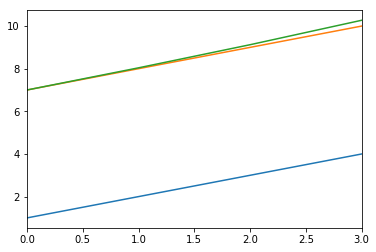

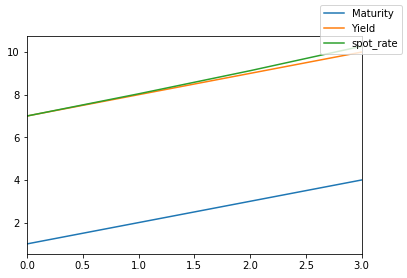

In [47]:
fig,ax = plt.subplots()
ax = a.plot(ax=ax,legend=False)
print(type(ax))
hl = ax.get_legend_handles_labels()

fig.legend(hl[0],hl[1])

plt.show()

In [49]:
print(hl[1])

['Maturity', 'Yield', 'spot_rate']


In [190]:
9.0000000000 / ( 1 + 8.0403964854/100.)**(1 + 1)

7.710280373834972

In [203]:
c ** .5

1.080403964854224

In [166]:
9/b + 9.0000000000 / ( 1 + 8.0403964854/100)**(1 + 1)

16.121495327106

In [64]:
b= 1.07

In [65]:
c = (108 / (100 - (8 / b)))

In [66]:
d = (109 / (100 - (9/c + 9/b)))

In [75]:
e = (110 / (100 - (10/d + 10/c + 10/b)))

In [77]:
a

,Maturity,Yield,spot_rate
0,1.0,7.0,7.000000
1,2.0,8.0,8.040396
2,3.0,9.0,9.127757
3,4.0,10.0,10.284585


In [76]:
print(b, c**.5, d**(1/3),e**.25 )

1.07 1.080403964854224 1.0912525530985964 1.102723634972019


In [11]:
import collateral_waterfall as cw
import prepayment_calcs as pc
import bond_pricing as bp
import scipy.interpolate as interpolate

In [15]:
spot_curve = bp.BondPricing.spot_from_par()

8.0000000000 / ( 1 + 7.0000000000/100)**(1)
9.0000000000 / ( 1 + 7.0000000000/100)**(1)
9.0000000000 / ( 1 + 8.0403964854/100)**(2)
10.0000000000 / ( 1 + 7.0000000000/100)**(1)
10.0000000000 / ( 1 + 8.0403964854/100)**(2)
10.0000000000 / ( 1 + 9.1252553099/100)**(3)


In [108]:
def forward_rates(spot_curve):
    maturities = spot_curve['Maturity']
    spots = spot_curve['spot_rate']
    
    if len(maturities) != len(spots):
        raise AttributeError('maturity and rate vector lengths must match')

    size = len(spots) -1
    forward = maturities[1:] - maturities[0]
    forward.name = 'Forward'
    print(forward)
    frame = pd.DataFrame(np.full((size,size),np.nan),columns=forward,index=maturities[:-1])

    for i in range(len(maturities)-1):
        for j in range(1,len(maturities)):
            #print(i,j)
            try:
                r2 = spots[i+j] / 100
                r1 = spots[i] / 100
                t2 = maturities[i+j]
                t1 = maturities[i]

                forward_rate = ((((1 + r2)**t2) / ((1 + r1)**t1)) ** (1/(t2-t1)) - 1) * 100
                frame.loc[t2-t1, t1] = forward_rate
                #print('r2: {}\nr1: {}\nt2: {}\nt1:{}'.format(r2,r1,t2,t1))
            except:
                pass
                #print('loop')

    return frame

In [109]:
forwards = forward_rates(spot_curve)

1    1.0
2    2.0
3    3.0
Name: Forward, dtype: float64


In [110]:
spot_curve2 = spot_curve.copy()
spot_curve2.loc[2,'spot_rate'] = 11
spot_curve2.loc[3,'Maturity'] = 10
forwards = forward_rates(spot_curve2)

1    1.0
2    2.0
3    9.0
Name: Forward, dtype: float64


In [103]:
forwards

Forward,1.0,2.0,9.0,3.0
Maturity,,,,
1.0,9.090909,17.164650,NaN,NaN
2.0,13.055730,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN
9.0,10.642082,NaN,NaN,NaN
8.0,NaN,10.837523,NaN,NaN
7.0,NaN,NaN,NaN,9.961981


In [2]:
import xlwings as xw
import collateral_waterfall as cw
wb = xw.Book('mbs waterfall.xlsx')

FileNotFoundError: No such file: 'mbs waterfall.xlsx'

In [50]:
sheet1 = wb.sheets(1)
values = sheet1.range('B1:B6').value

balance = values[0]
WAM = int(values[1])
WAC = values[2]
ptc = values[3]
speed = values[4]
cpr = values[5]

anchor = sheet1.range('A9')

waterfall = cw.create_waterfall(original_balance=balance,
                               wam=WAM,
                               wac=WAC,
                               pass_thru_cpn=ptc,
                               psa_speed=speed,
                               cpr_description=cpr)
anchor.expand().value = ""
anchor.value = waterfall

In [51]:
plt.close()
ax = waterfall['beginning_balance'].plot()
fig = ax.get_figure()

In [52]:
sheet1.pictures.add(fig, name='Adam',update=True)

<Picture 'Adam' in <Sheet [mbs waterfall.xlsx]Sheet1>>

In [53]:
wb = xw.Book()

In [142]:
OneYear = wb.sheets(1).range('OneYear').expand().options(pd.DataFrame).value
ThirtyYear = wb.sheets(1).range('ThirtyYear').expand().options(pd.DataFrame).value
OneYear.head()

,Yield
Date,
1995-02-13,6.82
1995-02-14,6.73
1995-02-15,6.64
1995-02-16,6.57
1995-02-17,6.61


In [141]:
plt.close()
ax1=None
ax2=None
fig1=None
fig2=None
ax1 = (OneYear/OneYear.shift(1)-1).plot()
ax1 = (ThirtyYear/ThirtyYear.shift(1)-1).plot(ax=ax1)
ax2 = (OneYear/OneYear[:1].values[0]).plot()
ax2 = (ThirtyYear/ThirtyYear[:1].values[0]).plot(ax=ax2)

fig1 = ax1.get_figure()
fig2 = ax2.get_figure()

wb.sheets(1).pictures.add(fig1)
wb.sheets(1).pictures.add(fig2)


<Picture 'Picture 26' in <Sheet [Book1]Sheet1>>

In [245]:
from IPython import display
def ex_4_3(quotes):
    df = pd.DataFrame(data=quotes,index=quotes.index, columns=['Yield'])
    df['Y_i/Y_i-1'] = quotes / quotes.shift(1)
    df['ln(Y_i/Y_i-1)'] = np.log(df['Y_i/Y_i-1'])
    stats = df.describe()
    stats.loc['ann_std'] = stats.ix['std'] * np.sqrt(250)
    stats = stats.loc[['mean','std','ann_std']]
    SD_in_BP = stats.loc['mean','Yield'] * stats.loc['ann_std','ln(Y_i/Y_i-1)'] * 100
    return df, stats, SD_in_BP

In [248]:
df, stats, SD_in_BP = ex_4_3(OneYear)
display.display(df, stats, SD_in_BP)
df, stats, SD_in_BP = ex_4_3(ThirtyYear)
display.display(df, stats, SD_in_BP)


,Yield,Y_i/Y_i-1,ln(Y_i/Y_i-1)
Date,,,
1995-02-13,6.82,NaN,NaN
1995-02-14,6.73,0.986804,-0.013284
1995-02-15,6.64,0.986627,-0.013463
1995-02-16,6.57,0.989458,-0.010598
1995-02-17,6.61,1.006088,0.006070
1995-02-20,6.60,0.998487,-0.001514
1995-02-21,6.65,1.007576,0.007547
1995-02-22,6.46,0.971429,-0.028988
1995-02-23,6.50,1.006192,0.006173


,Yield,Y_i/Y_i-1,ln(Y_i/Y_i-1)
mean,6.605000,0.994227,-0.005854
std,0.113847,0.011921,0.012029
ann_std,1.800077,0.188490,0.190192


1.2562178068871441

,Yield,Y_i/Y_i-1,ln(Y_i/Y_i-1)
Date,,,
1995-02-13,7.67,NaN,NaN
1995-02-14,7.61,0.992177,-0.007853
1995-02-15,7.56,0.993430,-0.006592
1995-02-16,7.57,1.001323,0.001322
1995-02-17,7.59,1.002642,0.002639
1995-02-20,7.59,1.000000,0.000000
1995-02-21,7.61,1.002635,0.002632
1995-02-22,7.54,0.990802,-0.009241
1995-02-23,7.55,1.001326,0.001325


,Yield,Y_i/Y_i-1,ln(Y_i/Y_i-1)
mean,7.582000,0.997965,-0.002047
std,0.041580,0.004692,0.004707
ann_std,0.657436,0.074195,0.074424


0.5642855091055845

,Yield,Y_i/Y_i-1,ln(Y_i/Y_i-1)
Date,,,
1995-02-13,6.82,NaN,NaN
1995-02-14,6.73,0.986804,-0.013284
1995-02-15,6.64,0.986627,-0.013463
1995-02-16,6.57,0.989458,-0.010598
1995-02-17,6.61,1.006088,0.006070
1995-02-20,6.60,0.998487,-0.001514
1995-02-21,6.65,1.007576,0.007547
1995-02-22,6.46,0.971429,-0.028988
1995-02-23,6.50,1.006192,0.006173


,Yield,Y_i/Y_i-1,ln(Y_i/Y_i-1)
mean,6.605000,0.994227,-0.005854
std,0.113847,0.011921,0.012029
ann_std,1.800077,0.188490,0.190192


1.2562178068871441

In [238]:
6.605000 * 0.190192

1.25621816

In [259]:
106 / (1+ 0.057 * np.exp(.40) )

97.692790494455949

In [272]:
x1 = np.array([1,5,9])
x2 = np.array([4,5,6])

In [280]:
print('\tSet1\tSet2')
print('avg:\t{}\t{}'.format(x1.mean(),x2.mean()))
print('1/av(x)\t{}\t{}'.format(1/x1.mean(),1/x2.mean()))
print('1/av(x)\t{:.2f}\t{:.2f}'.format(np.mean(1/x1),np.mean(1/x2)))

	Set1	Set2
avg:	5.0	5.0
1/av(x)	0.2	0.2
1/av(x)	0.44	0.21


In [281]:
1/x1

array([ 1.        ,  0.2       ,  0.11111111])

In [282]:
np.mean(1/x1)

0.43703703703703706

In [283]:
0.057 * np.exp(.4)

0.085034007765552408

In [284]:
prepay_sheet = wb.sheets('prepays')

In [308]:
CPR_diff = prepay_sheet.range('X1').expand().options(pd.DataFrame).value

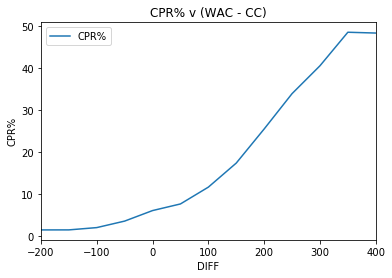

In [331]:
ax = CPR_diff.plot()
fig = ax.get_figure()
ax.set_title('CPR% v (WAC - CC)')
ax.set_xlabel('DIFF')
ax.set_ylabel('CPR%')
prepay_sheet.pictures.add(fig, name='CPR_DIFF', update=True, 
                          width=600, height=300)
plt.show()

In [346]:
CPRs = prepay_sheet.range('N1').expand().options(pd.DataFrame).value
Rates = prepay_sheet.range('D1').expand().options(pd.DataFrame).value

<class 'matplotlib.axes._subplots.AxesSubplot'>
[]


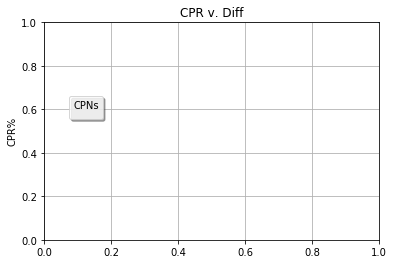

In [25]:
linestyles = [':','--','-.','--',':']
fig, ax = plt.subplots()
for col, linestyle in zip(CPRs.columns, linestyles):
    CPRs[col].plot(linestyle=linestyle, ax=ax, legend=False)
ax1 = Rates.plot(ax=ax, secondary_y=True, legend=True)
ax.set_ylabel('CPR%')
ax1.set_ylabel('Current Coupon')
ax.grid()
ax.set_title('CPR v. Diff')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles=handles, labels=labels,shadow=True,
          fancybox=True, bbox_to_anchor=(0.25,0.60), title='CPNs')
prepay_sheet.pictures.add(fig,name='fig1',update=True)
plt.show()

In [21]:
group = pd.groupby(CPRs,by=[CPRs.index.month])

NameError: name 'CPRs' is not defined

In [244]:
ex5_9 = pd.read_json('{"Current Coupon":{"0":8,"1":7,"2":6,"3":8,"4":9,"5":7},"WAC":{"0":9,"1":9,"2":9,"3":10,"4":7,"5":14},"Age":{"0":24,"1":50,"2":75,"3":50,"4":10,"5":120},"Factor":{"0":0.9,"1":0.8,"2":0.7,"3":0.6,"4":0.8,"5":0.4},"Month":{"0":"Jan","1":"Jul","2":"Mar","3":"Feb","4":"Oct","5":"Nov"}}')
seasonality = pd.read_json('{"Month":{"0":"Jan","1":"Feb","2":"Mar","3":"Apr","4":"May","5":"Jun","6":"Jul","7":"Aug","8":"Sep","9":"Oct","10":"Nov","11":"Dec","12":"Average"},"Average":{"0":4.8725,"1":4.6275,"2":6.165,"3":6.505,"4":7.0975,"5":7.565,"6":7.2825,"7":8.4375,"8":6.95,"9":6.945,"10":5.84,"11":5.72,"12":6.5025},"Factor":{"0":0.749526683,"1":0.711838836,"2":0.948349308,"3":1.000650811,"4":1.091793871,"5":1.163708437,"6":1.120252041,"7":1.297923323,"8":1.069104248,"9":1.068335108,"10":0.898355224,"11":0.87989587,"12":1.000266241}}')

In [125]:
seasonality.loc[seasonality['Month'] == 'Jan','Factor'][0]

0.74952668300000003

In [114]:
def age_perc(age, e=30):
    return min(age/e, 1)

In [251]:
def simple_model(current_coupon, wac, age, burn, month):
    diff = (wac - current_coupon) * 100
    interest_effect = interest_rate_effect(0.5,
                                             0.06,
                                             200,
                                             .006,
                                             diff)
    seasonal = seasonality.loc[seasonality['Month'] == month
                               ,'Factor'].values[0]
    features = {'Interest': interest_effect[4],
           'Age': age_perc(age=age),
           'Burnout': burn_perc(factor=burn),
           'Seasonal': seasonal}
    
    return features

In [252]:
def burn_perc(factor, f=0.7):
    return 1 - f * (1 - factor)

In [253]:
def interest_rate_effect(max_CPR, min_CPR, midpoint_diff, max_slope, diff=0):
    a = (max_CPR + min_CPR) / 2
    b = (max_CPR - a) / (np.pi/2)
    d = max_slope/b
    c = -d * midpoint_diff
    try:
        result = a + b * (np.arctan(c + d * diff))
    except Exception as e:
        print(e)
        result = 0
    return a, b, c, d, result 

In [254]:
a, b, c, d, result = interest_rate_effect(0.5,0.06,200,.006,100)

In [255]:
results = pd.DataFrame(columns=['Interest',
                                'Age',
                                'Burnout',
                                'Seasonal',
                                'Total'])

results = results.append(list(ex5_9.apply(lambda x: simple_model(x['Current Coupon'],
                                       x['WAC'],
                                       x['Age'],
                                       x['Factor'],
                                       x['Month']), axis=1)),
              ignore_index=True)
results['Total'] = results.apply(lambda x:
                                x['Interest'] * x['Age']
                                * x['Burnout'] * x['Seasonal'],
                                axis=1)

results

,Interest,Age,Burnout,Seasonal,Total
0,0.092118,0.800000,0.93,0.749527,0.051369
1,0.280000,1.000000,0.86,1.120252,0.269757
2,0.467882,1.000000,0.79,0.948349,0.350535
3,0.280000,1.000000,0.72,0.711839,0.143507
4,0.068164,0.333333,0.86,1.068335,0.020876
5,0.493466,1.000000,0.58,0.898355,0.257119


In [259]:
from IPython import display
print(ex5_9)
print(results)

   Age  Current Coupon  Factor Month  WAC
0   24               8     0.9   Jan    9
1   50               7     0.8   Jul    9
2   75               6     0.7   Mar    9
3   50               8     0.6   Feb   10
4   10               9     0.8   Oct    7
5  120               7     0.4   Nov   14
   Interest       Age  Burnout  Seasonal     Total
0  0.092118  0.800000     0.93  0.749527  0.051369
1  0.280000  1.000000     0.86  1.120252  0.269757
2  0.467882  1.000000     0.79  0.948349  0.350535
3  0.280000  1.000000     0.72  0.711839  0.143507
4  0.068164  0.333333     0.86  1.068335  0.020876
5  0.493466  1.000000     0.58  0.898355  0.257119
